# Hyper-parameter dependence of DRL models

In [1]:
import tensorflow as tf
import configparser
import numpy as np
import pandas as pd
import os
from drl_grams import *
import seaborn as sns

from state_env import State  # module with environment and dynamics
from RL_brain_pi_deep import DQNPrioritizedReplay  # sumtree version of DQN

2025-06-12 15:34:27.767316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Seed used: 1749753273


We base our algorithm in [1] but we add noise to training to solve a non-deterministic problem.
We optimize hyper-parameters using optuna library. We ran 50/100 trials for different chaing lengths.

Each folder in `optuna_drl` contains a summary file of stats and folders for individual trials containing the final model and the model that provided the best fidelity.



In [2]:
summary_file = 'optuna_drl/opt_for_n16_oaps_noise_per/summary.csv'
optuna_summary(summary_file,return_df=False)

Top 3 configurations based on binned_max_fid:
       Name  binned_max_fid  fc1_dims  learning_rate  epsilon_increment
0  trial_13        0.771413       598       0.008295           0.016131
1  trial_78        0.673650       266       0.012628           0.058734
2   trial_3        0.616965       488       0.013395           0.057740


In [ ]:
model_noise_summary('optuna_drl/opt_for_n16_oaps_noise_per/trial_13')

2025-06-12 15:34:33.054950: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-06-12 15:34:33.254106: E tensorflow/core/framework/node_def_util.cc:675] NodeDef mentions attribute grad_a which is not in the op definition: Op<name=MatMul; signature=a:T, b:T -> product:T; attr=transpose_a:bool,default=false; attr=transpose_b:bool,default=false; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_INT32, DT_INT64, DT_UINT8, DT_UINT16, DT_UINT32, DT_UINT64, DT_COMPLEX64, DT_COMPLEX128]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node train/gradients/eval_net/l2/MatMul_grad/MatMul}}


INFO:tensorflow:Restoring parameters from optuna_drl/opt_for_n16_oaps_noise_per/trial_13/final_model/model.ckpt
Model restored successfully!


2025-06-12 15:34:33.544175: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Restoring parameters from optuna_drl/opt_for_n16_oaps_noise_per/trial_13/final_model/model.ckpt
Testing with noise_amplitude: 0.0, noise_probability: 0.0


/home/sofi/Documentos/codigos/dynamic_control_for_QST/drl_grams.py:1822: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  noise_details = pd.concat(
/home/sofi/Documentos/codigos/dynamic_control_for_QST/drl_grams.py:1838: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  noise_effects = pd.concat(


Testing with noise_amplitude: 0.0, noise_probability: 0.1
Testing with noise_amplitude: 0.0, noise_probability: 0.2
Testing with noise_amplitude: 0.0, noise_probability: 0.30000000000000004
Testing with noise_amplitude: 0.0, noise_probability: 0.4
Testing with noise_amplitude: 0.0, noise_probability: 0.5
Testing with noise_amplitude: 0.0, noise_probability: 0.6000000000000001
Testing with noise_amplitude: 0.0, noise_probability: 0.7000000000000001


## N = 8



In [ ]:
# Load the results summary of 50 trials for chain of length 8
n8_summary = pd.read_csv('optuna_drl/opt_for_n8_oaps_noise_per/summary.csv')

The following graphs give an insight into the complicated dependence the results have on the selected hyper-parameters. 

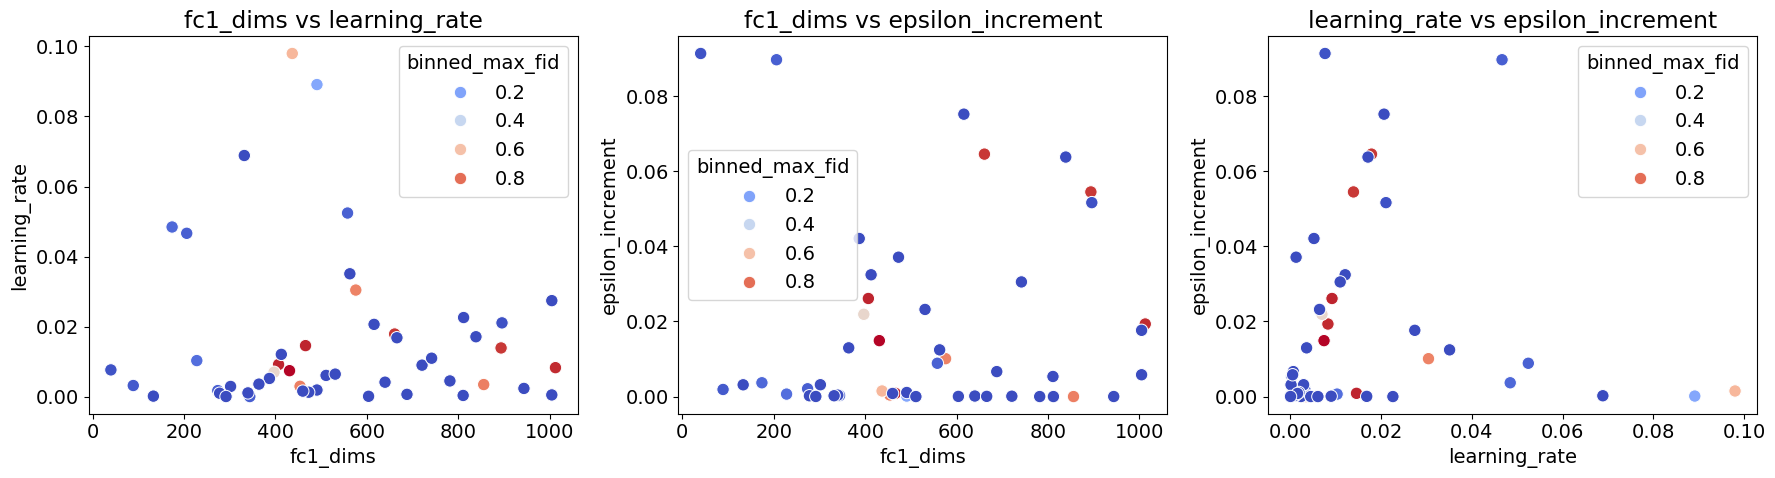

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(
    data=n8_summary,
    x='fc1_dims',
    y='learning_rate',
    hue='binned_max_fid',
    palette='coolwarm',
    s=80,
    ax=axes[0]
)
axes[0].set_title('fc1_dims vs learning_rate')

sns.scatterplot(
    data=n8_summary,
    x='fc1_dims',
    y='epsilon_increment',
    hue='binned_max_fid',
    palette='coolwarm',
    s=80,
    ax=axes[1]
)
axes[1].set_title('fc1_dims vs epsilon_increment')

sns.scatterplot(
    data=n8_summary,
    x='learning_rate',
    y='epsilon_increment',
    hue='binned_max_fid',
    palette='coolwarm',
    s=80,
    ax=axes[2]
)
axes[2].set_title('learning_rate vs epsilon_increment')

plt.tight_layout()
plt.show()

We consider the best model to be the one that achieves a higher fidelity when averaging over the last 100 episodes. The following table shows which trias provided the best results and the corresponding configuraions.

In [ ]:
n8_summary.sort_values(by='binned_max_fid', ascending=False).head(3)

# Display the top 3 configurations based on binned_max_fid
top_configs = n8_summary.sort_values(by='binned_max_fid', ascending=False).head(3)
print("Top 3 configurations based on binned_max_fid:")
print(top_configs[['Name', 'binned_max_fid', 'fc1_dims', 'learning_rate', 'epsilon_increment']])

Top 3 configurations based on binned_max_fid:
       Name  binned_max_fid  fc1_dims  learning_rate  epsilon_increment
0  trial_18        0.944262     431.0       0.007413           0.014893
1  trial_19        0.918034     407.0       0.009177           0.026114
2   trial_8        0.916027     466.0       0.014569           0.000873


### Loading model for top fidelities configuration



In [ ]:

# Load the RL model from the directory
directory = "optuna_drl/opt_for_n8_oaps_noise_per/trial_18"
# Find the config file in the directory

for file in os.listdir(directory):
    if file.endswith(".ini"):
        config_file = file
        break
    
config = configparser.ConfigParser()
# Read the config file
config.read(directory + "/" + config_file)

# Copy the config file to the current directory
current_directory = os.getcwd()
os.system(f"cp {directory}/{config_file} {current_directory}")

checkpoint_prefix = directory+'/final_model/model.ckpt'

# Load the model from the checkpoint
with tf.compat.v1.Session() as sess:
    # Restore the graph structure from the .meta file
    saver = tf.compat.v1.train.import_meta_graph(checkpoint_prefix + ".meta")
    
    # Restore the weights from the checkpoint
    saver.restore(sess, checkpoint_prefix)
    
    
    # The model is now loaded into the session
    print("Model restored successfully!")

input_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name("s:0")
output_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name("eval_net/l2/add:0")

2025-06-12 10:06:24.116535: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


INFO:tensorflow:Restoring parameters from optuna_drl/opt_for_n8_oaps_noise_per/trial_18/final_model/model.ckpt
Model restored successfully!


2025-06-12 10:06:24.608267: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


In [ ]:
env = State()  # environment

n8_noise_effects = pd.DataFrame(columns=['noise_amplitude', 'noise_probability', 'mean_fidelity'])    # we store the mean fidelity for each noise amplitude and probability
n8_noise_details = pd.DataFrame(columns=['noise_amplitude', 'noise_probability', 'action_sequence', 'max_fidelity', 'sequence'])

for noise_amplitude in np.linspace(0, 1, 11):
    for noise_probability in np.linspace(0, 1, 11):
        print(f"Testing with noise_amplitude: {noise_amplitude}, noise_probability: {noise_probability}")
        

        with tf.compat.v1.Session() as sess:
            # Restore the graph structure and weights again
            saver.restore(sess, checkpoint_prefix)

            number_of_episodes = 100
            lth = config.getint("system_parameters", "max_t_steps")
            
            print("max_t_steps: ", lth)

            best_action_sequences = [[] for i in range(0, 10)]
            best_fidelities = np.zeros(10)

            actionspace = []  # store successful actions
            Qvalue = []  # total reward
            fid_max_vector = []  # max. fidelity in each episode
            t_fid_max_vector = []  # time of max. fidelity
            fid_end_vector = []  # final fidelity
            t_end_vector = []  # time of final fidelity
            success_action_sequences = []  # store successful success_action_seq

            for episode in range(number_of_episodes):
                # Generate a complex normalized vector of 16 components
                observation = env.reset()
                
                newaction = []
                Q = 0
                fid_max = 0
                t_fid_max = 0

                for i in range(lth):  # episode maximum length
                    # Use the loaded model to predict the action
                    # Correct the shape of the observation before feeding it to the model
                    predicted_action = sess.run(output_tensor, feed_dict={input_tensor: np.expand_dims(observation, axis=0)})
                    predicted_action = np.argmax(predicted_action)
                    newaction.append(predicted_action)

                    observation_, reward, done, fidelity = env.noisy_step(predicted_action,noise_amplitude=noise_amplitude,noise_probability=noise_probability)  # take action in the environment

                    Q += reward  # total reward
                

                    # Save max. fidelity value
                    if fidelity > fid_max:
                        fid_max = fidelity
                        t_fid_max = i

                    if done:  # fidelity(reward) larger than threshold
                        newaction += [0 for xx in range(lth - len(newaction))]
                        actionspace.append(newaction)
                        Qvalue.append(Q)
                        fid_max_vector.append(fid_max)
                        fid_end_vector.append(fidelity)
                        t_fid_max_vector.append(t_fid_max)
                        t_end_vector.append(i + 1)

                        if fid_max > 0.9:
                            success_action_sequences.append(newaction)

                            break

                    observation = observation_  # Update current state

                if i == lth - 1:
                    actionspace.append(newaction)
                    fid_max_vector.append(fid_max)
                    fid_end_vector.append(fidelity)
                    t_fid_max_vector.append(t_fid_max)
                    t_end_vector.append(i + 1)
                    Qvalue.append(Q)

                    if fid_max > 0.9:
                        success_action_sequences.append(newaction)

                if fid_max > min(best_fidelities):
                    idx = np.argmin(best_fidelities)
                    best_fidelities[idx] = fid_max
                    best_action_sequences[idx] = newaction

                episodes = np.arange(0, number_of_episodes)

                n8_noise_details = pd.concat(
                    [
                        n8_noise_details,
                        pd.DataFrame(
                            {
                                "noise_amplitude": noise_amplitude,
                                "noise_probability": noise_probability,
                                "max_fidelity": fid_max,
                            },from scipy import stats

import matplotlib.pyplot as plt
                            index=[0],
                        ),
                    ],
                    ignore_index=True,
                )


            n8_noise_effects = pd.concat(
                    [
                        n8_noise_effects,
                        pd.DataFrame(
                            {
                                "noise_amplitude": noise_amplitude,
                                "noise_probability": noise_probability,
                                "mean_fidelity": np.mean(fid_max_vector),
                            },
                            index=[0],
                        ),
                    ],
                    ignore_index=True,
                )

Testing with noise_amplitude: 0.0, noise_probability: 0.0
INFO:tensorflow:Restoring parameters from optuna_drl/opt_for_n8_oaps_noise_per/trial_18/final_model/model.ckpt
max_t_steps:  40
34  0  0.9773452617419808
34  1  0.9773452617419808


/tmp/ipykernel_123230/697348683.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  n8_noise_details = pd.concat(


34  2  0.9773452617419808
34  3  0.9773452617419808
34  4  0.9773452617419808
34  5  0.9773452617419808
34  6  0.9773452617419808
34  7  0.9773452617419808
34  8  0.9773452617419808
34  9  0.9773452617419808
34  10  0.9773452617419808
34  11  0.9773452617419808
34  12  0.9773452617419808
34  13  0.9773452617419808
34  14  0.9773452617419808
34  15  0.9773452617419808
34  16  0.9773452617419808
34  17  0.9773452617419808
34  18  0.9773452617419808
34  19  0.9773452617419808
34  20  0.9773452617419808
34  21  0.9773452617419808
34  22  0.9773452617419808
34  23  0.9773452617419808
34  24  0.9773452617419808
34  25  0.9773452617419808
34  26  0.9773452617419808
34  27  0.9773452617419808
34  28  0.9773452617419808
34  29  0.9773452617419808
34  30  0.9773452617419808
34  31  0.9773452617419808
34  32  0.9773452617419808
34  33  0.9773452617419808
34  34  0.9773452617419808
34  35  0.9773452617419808
34  36  0.9773452617419808
34  37  0.9773452617419808
34  38  0.9773452617419808
34  39  0

/tmp/ipykernel_123230/697348683.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  n8_noise_effects = pd.concat(


max_t_steps:  40
34  0  0.9773452617419808
34  1  0.9773452617419808
34  2  0.9773452617419808
34  3  0.9773452617419808
34  4  0.9773452617419808
34  5  0.9773452617419808
34  6  0.9773452617419808
34  7  0.9773452617419808
34  8  0.9773452617419808
34  9  0.9773452617419808
34  10  0.9773452617419808
34  11  0.9773452617419808
34  12  0.9773452617419808
34  13  0.9773452617419808
34  14  0.9773452617419808
34  15  0.9773452617419808
34  16  0.9773452617419808
34  17  0.9773452617419808
34  18  0.9773452617419808
34  19  0.9773452617419808
34  20  0.9773452617419808
34  21  0.9773452617419808
34  22  0.9773452617419808
34  23  0.9773452617419808
34  24  0.9773452617419808
34  25  0.9773452617419808
34  26  0.9773452617419808
34  27  0.9773452617419808
34  28  0.9773452617419808
34  29  0.9773452617419808
34  30  0.9773452617419808
34  31  0.9773452617419808
34  32  0.9773452617419808
34  33  0.9773452617419808
34  34  0.9773452617419808
34  35  0.9773452617419808
34  36  0.97734526174

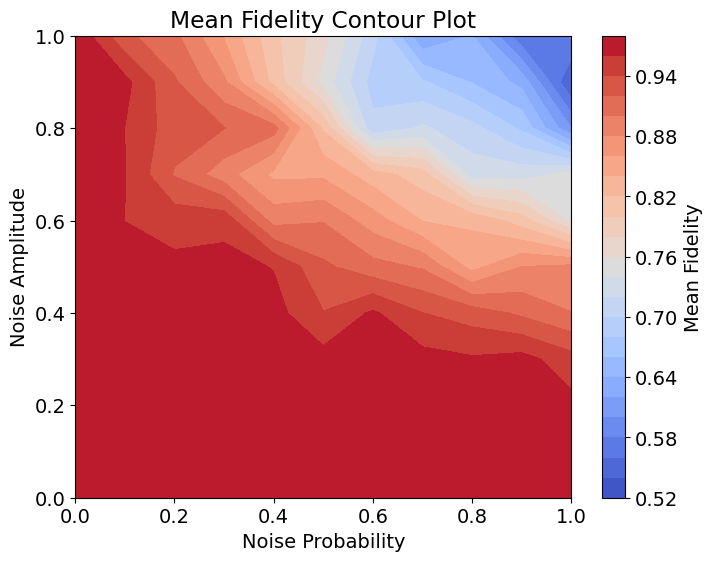

In [ ]:
pivot_data = n8_noise_effects.pivot(
    index='noise_amplitude',
    columns='noise_probability',
    values='mean_fidelity'
)

X, Y = np.meshgrid(pivot_data.columns.values, pivot_data.index.values)
Z = pivot_data.values

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=25, cmap='coolwarm')from scipy import stats

import matplotlib.pyplot as plt
plt.colorbar(contour, label='Mean Fidelity')
plt.xlabel('Noise Probability')
plt.ylabel('Noise Amplitude')
plt.title('Mean Fidelity Contour Plot')
plt.show()

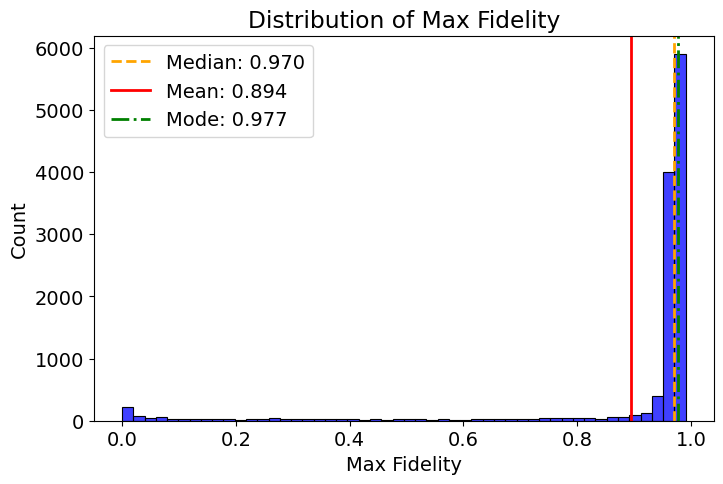

In [ ]:
from scipy import stats

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(n8_noise_details['max_fidelity'], bins=50, edgecolor='black')

# Calculate statistics
median = n8_noise_details['max_fidelity'].median()
mean = n8_noise_details['max_fidelity'].mean()
mode = n8_noise_details['max_fidelity'].mode().iloc[0]

# Plot vertical lines
plt.axvline(median, color='orange', linestyle='--', label=f'Median: {median:.3f}')
plt.axvline(mean, color='red', linestyle='-', label=f'Mean: {mean:.3f}')
plt.axvline(mode, color='green', linestyle='-.', label=f'Mode: {mode:.3f}')

plt.xlabel('Max Fidelity')
plt.ylabel('Count')
plt.title('Distribution of Max Fidelity')
plt.legend()
plt.show()